In [1]:
# логистическая регрессия

import pandas as pd                                         # для работы с датафреймом
import numpy as np                                          # для вычислений
import seaborn as sns                                       # для графиков
import matplotlib.pyplot as plt                             # для графиков

from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split        # для деления на обучающую и тестовую выборки
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Данные

In [2]:
# загружаем данные и исправляем тип данных
db = pd.read_csv('data/books_tidy_data.csv', parse_dates=['publication_date'], dtype={'decade':'object', 'quarter':'object', 'tra_co':'object'})

In [3]:
# удалим признаки, которые не будем рассматривать в данном исследовании
db = db.drop(['title', 'publication_date', 'authors', 'language_code', 'publisher'], axis=1)

In [4]:
db.head()

,average_rating,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co
0,4.57,652,2095690,27591,2000,3,1
1,4.49,870,2153167,29221,2000,3,1
2,4.42,352,6333,244,2000,4,0
3,4.56,435,2339585,36325,2000,2,1
4,4.78,2690,41428,164,2000,3,1


In [5]:
db.describe()

,average_rating,num_pages,ratings_count,text_reviews_count
count,10838.000000,10838.000000,1.083800e+04,10838.000000
mean,3.942158,344.175217,1.834788e+04,553.074737
std,0.295387,238.556381,1.138660e+05,2599.330244
min,1.000000,11.000000,0.000000e+00,0.000000
25%,3.770000,203.000000,1.170000e+02,10.000000
50%,3.960000,304.000000,8.035000e+02,49.000000
75%,4.130000,417.000000,5.226750e+03,248.000000
max,5.000000,6576.000000,4.597666e+06,94265.000000


<AxesSubplot:xlabel='num_pages', ylabel='average_rating'>

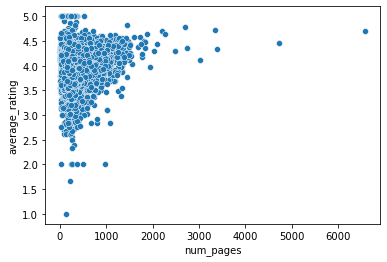

In [6]:
sns.scatterplot(x='num_pages', y='average_rating', data=db)

На основе предыдущих исследований количество страниц самый перспективный признак, на графике видно, что явно имеются выбросы. Среднее составляет 3.94 со стандартным отклонением 0.3. Мы будем решать задачу бинарной классификации, когда 0 - это плохие оценки (1,2,3), а 1 - хорошие, то есть 4 и 5.

In [7]:
bins = [0, 4, 5]            # группы, на которые мы разобьем среднюю оценку
groups_names = ['0', '1']   # название этих групп
db['rating_groups'] = pd.cut(db['average_rating'], bins, labels=groups_names, right=True).astype('int64') # проводим разбиение на группы
db = db.drop(['average_rating'], axis=1) # удаляем количественный признак, на основании которого построили бинарный

In [8]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10838 entries, 0 to 10837
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   num_pages           10838 non-null  int64 
 1   ratings_count       10838 non-null  int64 
 2   text_reviews_count  10838 non-null  int64 
 3   decade              10838 non-null  object
 4   quarter             10838 non-null  object
 5   tra_co              10838 non-null  object
 6   rating_groups       10838 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 592.8+ KB


In [9]:
db.head()

,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,rating_groups
0,652,2095690,27591,2000,3,1,1
1,870,2153167,29221,2000,3,1,1
2,352,6333,244,2000,4,0,1
3,435,2339585,36325,2000,2,1,1
4,2690,41428,164,2000,3,1,1


Проверим, сколько наблюдений содержит каждый класс.

In [10]:
db['rating_groups'].value_counts(normalize=True)

0    0.574276
1    0.425724
Name: rating_groups, dtype: float64

Видим, что классы значительно различаются по количеству наблюдений. Следовательно, нужно будет решать задачу по дисбалансу классов.  

Мы будем использовать три подхода: 1) визуальный, 2) статистический, 3) машинное обучение. Визуализировать данные необходимо, так как именно визуально легче схватить какие-то значимые характеристики распределения данных (если данные это позволяют). Статистический подход необходим, чтобы понимать, как работает логистическая регрессия "под капотом". Машинное обучение позволяет проводить множество различных манипуляций с данными для улучшения модели предсказания.

Важно понимать разницу межу чисто статистическим подходом и машинным обучением. Для статистического подхода не требуется разделять данные на тренировочный и тестовый наборы.  

Мы применим большинство подходов, о которых упоминается в учебниках.

# Ищем простое решение
Всегда нужно исходить из бритвы Оккама: не надо плодить дополнительные сущности. Поэтому проведем проверку наших данных, как они есть.  

Книги о логистической регрессии:  
1) Изучаем Pandas М.Хейдт, А.Груздев (обязательно второе издание)  
2) Статья Binary Logistic Regression (datasklr.com)  

Суть метода логистической регрессии заключается в следующем:  
1) имеются признаки (количество страниц и др.) и целевой признак (0 - плохая оценка, 1 - хорошая оценка). Цель по имеющимся признакам предсказать целевой признак.  
2) вместо предсказания непосредственно целевого признака, мы предскажем вероятность класса 1 для конкретного наблюдения. Для этого будем работать не с самим классом, а с его вероятностью. Нужно использовать не саму вероятность, а натуральный логарифм шанса.  
3) в этом случае формула расчета приобретает вид, аналогичный линейной регрессии: слева логарифм шанса, а справа - признаки с коэффициентами.  
4) мы предсказываем логарифм по признакам с коэффициентами. Мы можем подогнать коэффициенты так, чтобы получить любой логарифм. Но так не пойдет, нам нужен механизм оценки вероятности. Поэтому используется метод максимального правдоподобия: считаем по всему набору данных, какой должна быть вероятность получить класс 1, чтобы у нас получилось ровно n наблюдений класса 1. Далее, мы подгоняем за счет коэффициентов наше уравнение с логарифмом таким образом, чтобы приблизиться максимально близко к оценке вероятности по всем наблюдениям. Другими словами, например, у нас 10 строк с наблюдениями. Мы подбираем такой коэффициент для каждого признака, чтобы умножение на него каждого наблюдения в признаке (и сложение по каждому признаку, умноженному по каждому наблюдению) на выходе давало максимальное приближение к вероятности, полученной ранее.

In [11]:
import statsmodels.formula.api as smf # модуль, который позволяет задать формулу в стиле R
model0 = smf.logit('rating_groups ~ num_pages + ratings_count + text_reviews_count + C(decade) + C(quarter) + C(tra_co)', data = db).fit() # вызываем и обучаем модель

         Current function value: 0.665534
         Iterations: 35
/Users/Shared/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
print(model0.summary()) # вызов результатов модели

                           Logit Regression Results                           
Dep. Variable:          rating_groups   No. Observations:                10838
Model:                          Logit   Df Residuals:                    10818
Method:                           MLE   Df Model:                           19
Date:                Sat, 05 Jun 2021   Pseudo R-squ.:                 0.02425
Time:                        20:08:14   Log-Likelihood:                -7213.1
converged:                      False   LL-Null:                       -7392.3
Covariance Type:            nonrobust   LLR p-value:                 1.789e-64
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -22.8836   7.01e+04     -0.000      1.000   -1.38e+05    1.37e+05
C(decade)[T.1910]     21.2115   7.01e+04      0.000      1.000   -1.37e+05    1.37e+05
C(decade)[T.1920]   

Разберем этот вывод.  
- coef - это коэффициенты при независимых переменных в формуле логистической регрессии, где зависимой переменной выступает логит. Регрессионный коэффициент - это изменение логарифма отношения шансов данной зависимой переменной на единицу изменения независимой переменной при постоянных значениях всех остальных независимых переменных.
- P > |z| - это p-value. Нулевая гипотеза состоит в том, что коэффициент равен нулю.
- Log-Likelihood - это натуральный логарифм функции оценки максимального правдоподобия.
- LL-Null - это значение логарифмической вероятности модели, когда независимая переменная не включена (включен только перехват).
- LLR p-value - это проверка на принятие нулевой гипотезы: модель, в которой все коэффициенты равны 0 и которая определяется точкой пересечения с осью y, лучше, чем модель, в которой есть коэффициенты. Мы можем отклонить нулевую гипотезу.
- Pseudo R-squ - это отношение логарифмической вероятности нулевой модели к полной модели. То же, что коэффициент детерминации в линейной регрессии. Показывает уровень объясненной дисперсии. Чем ближе к 1, тем лучше. У нас это всего 0.024, то есть модель может объяснить только 2.4% дисперсии.
- Z-оценка - это коэффициент, деленный на стандартную ошибку. Чем ниже, тем лучше.  

Коэффициент для num_pages составляет 0.0014. Это значит, что для каждого увеличения количества страниц увеличиваются логарифмические шансы (не вероятность, а именно логарифм шанса), что книга имеет положительную оценку.

# Визуальный подход

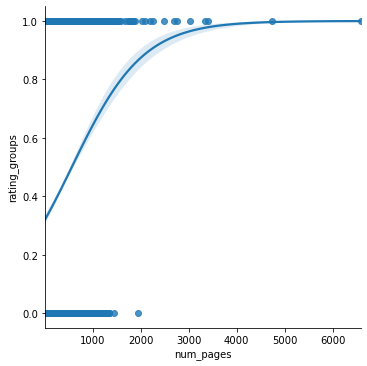

In [13]:
sns.lmplot(x = 'num_pages', y = 'rating_groups', data = db, logistic=True)

Линия регрессии показывает вероятность получить оценку 1 или 0. Например, при количестве страниц 1000 вероятность получить оценку 1 близка к 0.6.

# Статистический подход
## Подготовка признаков

Будем работать с отдельной копей наших данных, машинное обучение будем проводить на другой копии.  

1. Укрупним категории. Если категорий в признаке слишком много и они содержат мало наблюдений, то такие категории плохо будут разделять целевой признак на 0 и 1.  
2. Получим новые признаки.  
3. Масштабируем наши данные.

In [14]:
db_stat = db.copy()

In [16]:
# начнем с категориальных данных
# количество по категориям в процентах
db_stat['decade'].value_counts(normalize=True)

2000    0.676509
1990    0.224765
1980    0.056283
1970    0.018454
2010    0.012641
1960    0.006643
1950    0.002676
1920    0.000738
1940    0.000646
1910    0.000277
1930    0.000185
1900    0.000092
2020    0.000092
Name: decade, dtype: float64

In [17]:
# количество по категориям 
db_stat['decade'].value_counts()

2000    7332
1990    2436
1980     610
1970     200
2010     137
1960      72
1950      29
1920       8
1940       7
1910       3
1930       2
1900       1
2020       1
Name: decade, dtype: int64

Имеются категории, в которых всего несколько наблюдений. Очевидно, что такие категории не помогут в разделении цеелвого признака на 0 и 1, поэтому укрупним категории.

In [18]:
db_stat['decade'] = db_stat['decade'].replace(['1900','1910','1920','1930','1940','1950','2020'],'1960')

In [19]:
db_stat['decade'].value_counts()

2000    7332
1990    2436
1980     610
1970     200
2010     137
1960     123
Name: decade, dtype: int64

In [20]:
db_stat['quarter'].value_counts(normalize=True)

3    0.263056
4    0.250415
2    0.249769
1    0.236760
Name: quarter, dtype: float64

In [21]:
db_stat['tra_co'].value_counts(normalize=True)

0    0.599004
1    0.400996
Name: tra_co, dtype: float64

Распределение по кварталам и соавторству примерно одинаковое.  
Рассмотрим количественные признаки. Поделим количество оценок на количество отзывов (сколько приходится на один отзыв оценок).

In [22]:
db_stat['rating_reviews']= db_stat['ratings_count'] / db_stat['text_reviews_count']
# в результате деления может возникнуть NaN, заменим его на 1
db_stat['rating_reviews'].replace(np.nan,1,inplace=True)
# избавимся от бесконечности
db_stat['rating_reviews'].replace([np.inf, -np.inf],1,inplace=True)

Создадим новый признак: среднее значение количества страниц, если у книги есть соавто/переводчик.   
Для этого будем использовать функцию.
На вход функция принимает:  
- data - данные;
- cat-feat - категориальный признак;
- real-feat - количественный признак.  

Функция возвращает новый столбец данных, в котором для каждой группы в категориальных данных определяется среднее количественного признака.

In [23]:
def code_mean(data, cat_feat, real_feat):
    return (data[cat_feat].map(data.groupby(cat_feat)[real_feat].mean()))

In [24]:
db_stat['pages_decade'] = code_mean(db_stat, 'decade', 'num_pages')

In [25]:
db_stat

,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,rating_groups,rating_reviews,pages_decade
0,652,2095690,27591,2000,3,1,1,75.955565,341.866067
1,870,2153167,29221,2000,3,1,1,73.685603,341.866067
2,352,6333,244,2000,4,0,1,25.954918,341.866067
3,435,2339585,36325,2000,2,1,1,64.407020,341.866067
4,2690,41428,164,2000,3,1,1,252.609756,341.866067
...,...,...,...,...,...,...,...,...,...
10833,512,156,20,2000,4,1,1,7.800000,341.866067
10834,635,783,56,1980,4,0,1,13.982143,371.821311
10835,415,820,95,1990,3,0,0,8.631579,351.500411
10836,434,769,139,2000,1,0,0,5.532374,341.866067


Масштабируем количественные признаки. Для этого можно использовать робастный планировщик, так как у нас есть выбросы. Но можно попробовать и другие.  
Определим признак, который будем шкалировать, передаим его шкалировщику, заменим исходный признак на масштабированный.  
Масштабирование желательно, но не обязательно. Масштабирование применяется, если признаки представлены разными шкалами (граммы и сантиметры) или значения одного признака слишком "отрываются" от другого. Это не наш случай, но мы все-таки применим этот метод.

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [27]:
# на основе тестов лучше всего справилось квантильное шкалирование, применим его
# список количественных признаков
col_names = ['num_pages', 'ratings_count', 'text_reviews_count', 'rating_reviews', 'pages_decade']
# создаем датафрейм с количественными признаками
features = db_stat[col_names]
# вызываем и обучаем шкалировщик
scaler = QuantileTransformer(n_quantiles=10, random_state=0).fit(features.values)
# преобразуем наши данные
features = scaler.transform(features.values)
# применяем результаты
db_stat[col_names] = features

# Обучение

In [28]:
# вызываем и обучаем модель
model = smf.logit('rating_groups ~ num_pages + ratings_count + text_reviews_count + C(decade) + C(quarter) + C(tra_co) + rating_reviews + pages_decade', data=db_stat).fit()

         Current function value: 0.662033
         Iterations: 35
/Users/Shared/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:          rating_groups   No. Observations:                10838
Model:                          Logit   Df Residuals:                    10824
Method:                           MLE   Df Model:                           13
Date:                Sat, 05 Jun 2021   Pseudo R-squ.:                 0.02938
Time:                        21:00:25   Log-Likelihood:                -7175.1
converged:                      False   LL-Null:                       -7392.3
Covariance Type:            nonrobust   LLR p-value:                 1.211e-84
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.7659        nan        nan        nan         nan         nan
C(decade)[T.1970]     -0.0740        nan        nan        nan         nan         nan
C(decade)[T.1980]   

Value стало ниже (0.6620), но зато увеличилась объясненная дисперсия (0.029) и Log-Likelihood (7175), а также коэффициент при num_pages стал 0.5943. Можно попробовать другие шкалировщики.  
Модель хорошо реагирует на применение робастных шкалировщиков. Проблемы выбросов - одна из главных в наших данных и без ее решения получить примелемые результаты сложно. Здесь нас интересует механика, а не конкретный результат.

<AxesSubplot:>

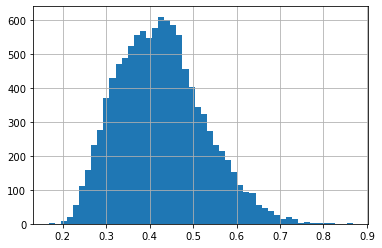

In [30]:
# получаем значение вероятности
proba = 1 / (1 + np.exp(-model.fittedvalues))
proba.hist(bins=50)

Эффективная модель делила бы вероятности на два класса, ближе к 0 или к 1.  
Неэффективная сосредотачивает вероятности возле 0.5.